In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

data = []

def encode_employment_status(row):
    current_years = None
    if 'positions' in row:
        curr_pos_list = list(filter(lambda x: x['end_date'] is None, row['positions']))
        if curr_pos_list:
            curr_pos = curr_pos_list[0]
            current_years = curr_pos['current_years_at_company']
    if current_years is None:
        return 'unemployed'
    elif current_years < 1.0:
        return 'less_than_1'
    elif current_years < 3:
        return '1to3'
    elif current_years < 5:
        return '3to5'
    else:
        return '5plus'


# TODO F_Industry isn't very usable
with open('data-science-challenge-data.json') as f:
    for jsonObj in f:
        row = json.loads(jsonObj)
        for key in row['features']['f_scores']:
            row[key] = row['features']['f_scores'][key]
        for key in row['features']:
            row[key] = row['features'][key]
        for col in ['id', 'person_id', 'features', 'date_contacted', 'date_responded', 'job']:
            del row[col]
        row['status'] = encode_employment_status(row)
        for key in ['educations', 'F_Industry', 'f_scores', 'positions', 'currently_employed']:
            if key in row:
                del row[key]

        data.append(row)


In [2]:
X = pd.DataFrame(data)
X["intersted_in_role"] = X["intersted_in_role"].fillna(False).astype(int)
X["F_CompanySize"] = X["F_CompanySize"].fillna(0.5).astype(float)

X.dtypes


intersted_in_role              int64
F_Co                           int64
F_Major                        int64
F_School                       int64
F_Keyword                    float64
F_Layoffs                    float64
F_GradSchool                   int64
F_Interested                 float64
F_StartupExp                   int64
F_CompanySize                float64
candidate_score              float64
match_score                  float64
total_years_of_experience    float64
status                        object
dtype: object

In [3]:
for col in X:
    print(X[col].value_counts(dropna=False))
    print('-' * 20)


0    9565
1     435
Name: intersted_in_role, dtype: int64
--------------------
1        2998
5        2089
10000    1568
3        1285
4        1165
7         282
6         254
2         235
8          92
10         31
9           1
Name: F_Co, dtype: int64
--------------------
1        5787
2        1391
4        1359
3         942
10000     521
Name: F_Major, dtype: int64
--------------------
1        2710
10000    2563
2        1808
4        1723
3        1186
5          10
Name: F_School, dtype: int64
--------------------
0.000000    3092
1.000000    2822
0.500000    1392
0.666667     860
0.250000     643
0.333333     625
0.750000     466
0.600000      39
0.400000      29
0.800000      23
0.200000       9
Name: F_Keyword, dtype: int64
--------------------
0.000000    9087
0.611431      23
0.948988      23
0.328127      21
0.953024      19
            ... 
0.117464       1
0.005360       1
0.013789       1
0.867994       1
0.699167       1
Name: F_Layoffs, Length: 246, dtype: int64


<AxesSubplot:>

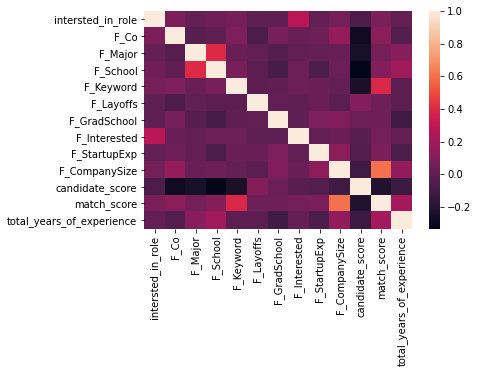

In [4]:
import seaborn as sns
corr = X.corr()
sns.heatmap(corr, xticklabels=True, yticklabels=True)


In [5]:
categorical_features = ['F_Co', 'F_Major', 'F_GradSchool', 'F_School', 'status']
for col in categorical_features:
    encoded_features = pd.get_dummies(X[col], prefix=col)
    X = pd.concat([X, encoded_features], axis=1)
    del X[col]

<AxesSubplot:>

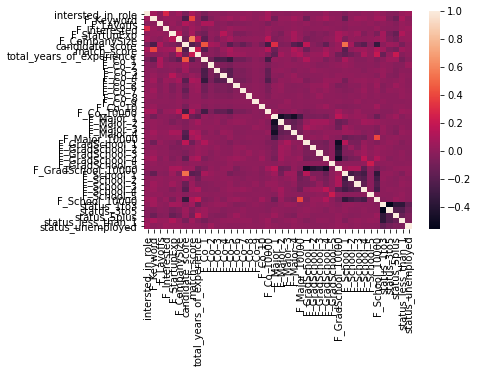

In [6]:
import seaborn as sns
corr = X.corr()
sns.heatmap(corr, xticklabels=True, yticklabels=True)


In [7]:
y = X['intersted_in_role']
del X['intersted_in_role']


In [8]:
cols = X.columns.values.tolist()


In [9]:
y = y.to_numpy(dtype=float)
X = X.to_numpy(dtype=float)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, stratify=y)


In [11]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC(C=1.0e-2, penalty='l1', dual=False, loss='squared_hinge', class_weight='balanced'))
])

pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 LinearSVC(C=0.01, class_weight='balanced', dual=False,
                           penalty='l1'))])

In [12]:
y_test_pred = pipe.predict(X_test)
y_train_pred = pipe.predict(X_train)

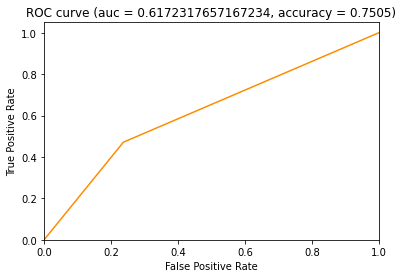

In [13]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_test_pred)
auc_test = roc_auc_score(y_test, y_test_pred)
acc_test = accuracy_score(y_test, y_test_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve (auc = {auc_test}, accuracy = {acc_test})')

plt.show()


In [14]:
coeffs = pipe.named_steps['svc'].coef_.tolist()[0]
zipped = list(zip(cols, coeffs))
zipped.sort(key=lambda x: x[1], reverse=True)
cols = [col for col, _ in zipped]
coeffs = [coeff for _, coeff in zipped]


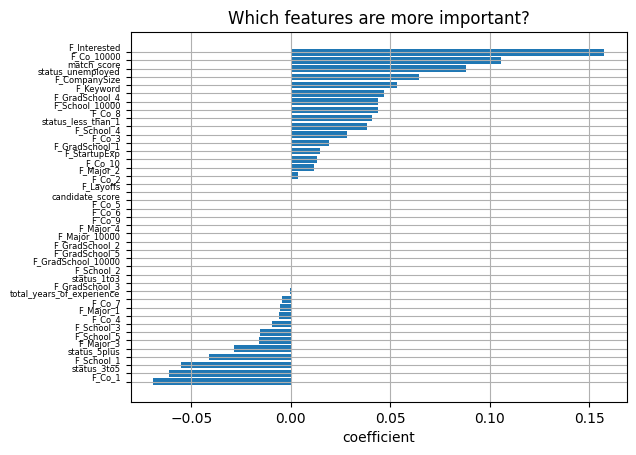

In [15]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(coeffs))

ax.barh(y_pos, coeffs, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(cols, va='bottom', fontsize=6)
ax.tick_params(axis='y', pad=4)
ax.grid()
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('coefficient')
ax.set_title('Which features are more important?')
plt.show()
